### Model and problem

Consider a regression model:

$$ Y_i = f^*(X_i) + \varepsilon_i,~~1 \leq i \leq n, $$

where 
* $f^∗$ is an unknown univariate function on $[0,1]$, 
* the design points equidistant, i.e. $X_i=\frac{i}{n} ~ \forall ~ 1 \leq i \leq n$, 
* $\varepsilon_i$  are independent zero-mean Gaussian random variables. 

We consider two situations:

1) **homogeneous noise:** the errors $\varepsilon_1, \dots, \varepsilon_n $ are identically distributed with respect to $N(0,\sigma^2)$ and $\sigma^2$ is known,

2) **inhomogeneous noise:** $\varepsilon_i \sim N(0, \sigma_i^2)$ with unknown $\sigma_i^2$ but an averaged value $\sigma^2=\frac{\sigma_1^2 + \dots + \sigma_n^2}{n}$ is given.

The **goal** is to estimate a target functional $\phi^*$ with an adaptive method:

$$ \phi^* = (f^*)' $$

Loss: 

$$ R(\hat{f'}) = ||\hat{f'} - (f^*)'||_n^2 = \frac{1}{n} \sum_{i} (\hat{f'}(X_i) - (f^*)'(X_i))^2 $$

We approximate the function $f^∗$ by **smoothing splines**. 

We use **unbiased risk estimation as model selection procedure**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

### Step 0: the sample size

In [2]:
n = 200 # number of observations
x = np.linspace(0, 1, n) # design points

### Step 1: generate the function $f^*$

Given the Fourier basis $\{\psi_j(x)\}_{j=1}^n$, the true function is generated by

$$ f^*(x) = c_1 \psi_1(x) + \dots + c_n \psi_n(x), $$

where the coefficients $c_1,\dots,c_n$ are chosen randomly: with $\gamma_j$ i.i.d. standard normal.

\begin{equation*}
c_j = 
 \begin{cases}
   \gamma_j,& 1 \leq j \leq 10 \\
   \frac{\gamma_j}{(j-10)^2}, & 11 \leq j \leq n
 \end{cases}
\end{equation*}

$$    $$

In [3]:
class OriginalFunction():
    def __init__(self, n, seed=20):
        self.n = n # basis size n should be even
        self.c = self._construct_coeffs(seed)
        
    def __call__(self, x):
        basis_x = self._basis(x)
        return np.dot(basis_x.T, self.c)
    
    def derivative(self, x):
        dbasis_x = self._dbasis(x)
        return np.dot(dbasis_x.T, self.c)        

    def _construct_coeffs(self, seed):
        np.random.seed(seed)
        c = np.zeros(self.n)
        c[:10] = np.random.normal(loc=0, scale=1, size=10) # note that indexation from 0
        c[10:] = np.random.normal(loc=0, scale=1, size=n - 10) / np.square(np.arange(11, n + 1) - 10)
        return c

    def _basis(self, x):
        basis_x = np.zeros((self.n, x.shape[0]))
        ind_range = np.arange(0, self.n / 2).reshape(-1, 1)
        basis_x[1::2, :] = np.sin(2 * np.pi * x * ind_range) # odd rows
        basis_x[::2, :] = np.cos(2 * np.pi * x * ind_range) # even rows
        return basis_x

    def _dbasis(self, x):
        dbasis_x = np.zeros((self.n, x.shape[0]))
        ind_range = np.arange(0, self.n / 2).reshape(-1, 1)
        dbasis_x[1::2, :] = 2 * np.pi * ind_range * np.cos(2 * np.pi * x * ind_range) # odd rows
        dbasis_x[::2, :] = - 2 * np.pi * ind_range * np.sin(2 * np.pi * x * ind_range) # even rows        
        return dbasis_x

In [4]:
def plot_true_func_and_derivative(x, f, df):
    plt.rcParams.update({'font.size': 11})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    ax1.plot(x, f, linewidth=3)
    ax1.set_title('True function $f^∗$')
    ax1.set_xlabel('x')
    ax1.set_ylabel('$f^∗(x)$')
    ax1.grid()
    
    zero_line = x * 0
    ax2.plot(x, df, linewidth=3)    
    ax2.plot(x, zero_line, linestyle='dashed', linewidth=3)
    ax2.set_title('Derivative of the true function $f^∗$')
    ax2.set_xlabel('x')
    ax2.set_ylabel('$df^∗(x)/dx$')
    ax2.grid()
    
    plt.show()

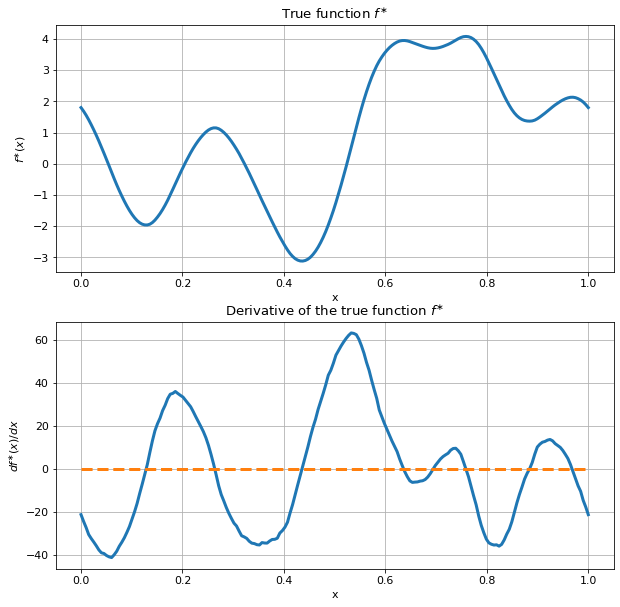

In [5]:
f_true = OriginalFunction(n)
f_true_x = f_true(x)
df_true_x = f_true.derivative(x)
plot_true_func_and_derivative(x, f_true_x, df_true_x)

### Step 2: generate the variances

In [6]:
def construct_variances(n, seed=20):
    np.random.seed(seed)
    mean = 2 * np.ones(n)
    cov = 0.4 * np.eye(n)
    var = np.random.multivariate_normal(mean=mean, cov=cov)
    var = 0.8**2 * np.square(var)
    var = np.sort(var)
    return var

def plot_true_and_observed(x, f_true, f_obs_homo, f_obs_inhomo):
    plt.rcParams.update({'font.size': 11})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    ax1.plot(x, f_true, linewidth=3, label='True')
    ax1.scatter(x, f_obs_homo, marker='o', label='Observed', c='orangered', alpha=0.7)
    ax1.set_title('True and observed values (homogeneous noise)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('$y$')
    ax1.grid()
    ax1.legend()
    
    ax2.plot(x, f_true, linewidth=3, label='True')
    ax2.scatter(x, f_obs_inhomo, marker='o', label='Observed', c='orangered', alpha=0.7)
    ax2.set_title('True and observed values (inhomogeneous noise)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('$y$')
    ax2.grid()
    ax2.legend()
    
    plt.show()

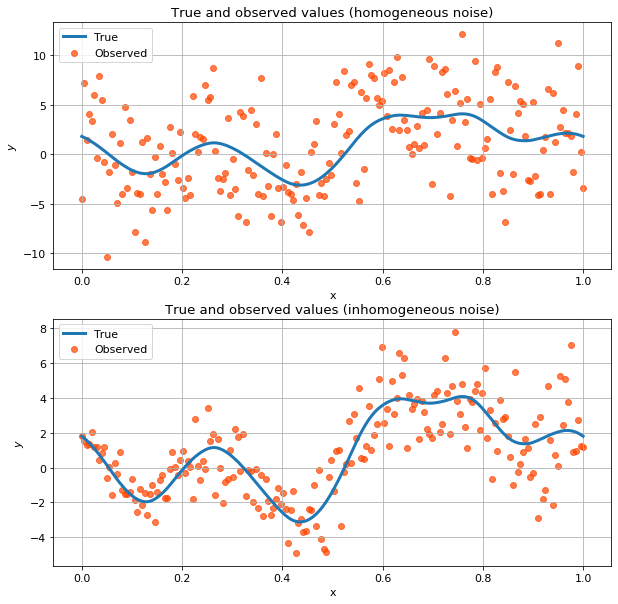

In [7]:
var_homo = construct_variances(1)
var_inhomo = construct_variances(n)

noise_homo = np.random.normal(loc=0, scale=var_homo, size=n)
noise_inhomo = np.random.multivariate_normal(mean=np.zeros(n), cov=np.diag(var_inhomo))

f_obs_homo = f_true_x + noise_homo
f_obs_inhomo = f_true_x + noise_inhomo

plot_true_and_observed(x, f_true_x, f_obs_homo, f_obs_inhomo)

### Step 3: oracle choice and oracle risk

In the case of **smoothing splines** we solve the following problem:

$$ \sum_{i=1}^{n} (Y_i - f(X_i))^2 + \alpha \underset{X} \int (f''(x))^2 dx \rightarrow \underset{f} \min  $$

$ x_i \in X, $ where $X$ is a space of features.

The solution of the problem is a **cubic spline** with knots at the design points $x_i, \dots, x_n$.

Therefore, we use the following **basis**:

* $\psi_j(x) = x^j,~~0 \leq j \leq 3$
* $\psi_j(x) = (x-x_{j-3})_{+}^3,~~4 \leq j \leq n + 2$

Note that we do not take a function $(x-x_{n})_{+}^3, ~~ x_n=1$ because it is **zero** for all $x \in [0, 1]$.

Overall **number of parametrs**: $n + 3$.

Basis matrix $\Psi(x)$ has shape $ (n + 3) \times n $:

$$ \Psi(x) = (\psi_0(x), \dots , \psi_{n+2}(x))^{\top} $$

We want to find $\theta$ such that

$$ \theta = (\theta_0, \dots, \theta_{n+2})^{\top} $$

$$ f(x) = \sum_{j=0}^{n+2} \theta_j \psi_j(x) = \Psi(x)^{\top} \theta $$

Then the second derivative is

$$ f''(x) = \sum_{j=0}^{n+2} \theta_j \psi_j''(x) $$

Then we calculate penalty term $\alpha \underset{X} \int (f''(x))^2 dx$ in the following way:

$$(f''(x))^2 = \sum_{i, j=0}^{n+2} \theta_i \theta_j \psi_i''(x) \psi_j''(x) = \theta^{\top} A(x) \theta $$

$$A_{ij}(x) = \psi_i''(x) \psi_j''(x)$$

$$\underset{X} \int (f''(x))^2 dx = \underset{X} \int \theta^{\top} A(x) \theta dx = \theta^{\top} (\underset{X}\int A(x) dx ) \theta = 
\theta^{\top} \bar{A} \theta $$

$$ \bar{A}_{ij} = \underset{X} \int \psi_i''(x) \psi_j''(x) dx = \int_{0}^{1} \psi_i''(x) \psi_j''(x) dx $$

We can rewrite our optimization problem in the form:

$$ ||Y - \Psi^{\top} \theta ||^2 + \alpha \theta^{\top} \bar{A} \theta \rightarrow \underset{\theta} \min $$

Optimal solution is

$$ \tilde{\theta}_m = \underbrace{(\Psi \Psi^{\top} + \alpha \bar{A})^{-1} \Psi}_{S_m} Y $$

*Index $m$ here refers to particular model with fixed parameter $\alpha$.*

The estimate of the original function can be computed as

$$ \tilde{f}_m = \Psi^{\top} \tilde{\theta}_m = \Psi^{\top} S_m Y $$

The estimate of the derivative:

$$ \tilde{f'}_m = (\Psi')^{\top} \tilde{\theta}_m = \underbrace{(\Psi')^{\top} S_m}_{K_m} Y = K_m Y $$

In [8]:
class SmoothingSpline():
    def __init__(self, knots, y, alpha=1):        
        self.x_min = knots[0]
        self.x_max = knots[-1]
        self.knots = knots
        self.knots_size = len(knots)
        self.basis_size = self.knots_size + 3
        self.alpha = alpha
        self.y = y
        
        self.basis_x = self._basis(x) 
        self.A_integral = self._compute_A_integral()
        self.S = self._compute_S()
        self.theta = self._compute_optimal_theta()
    
    def __call__(self, x0):
        basis_x0 = self._basis(x0)
        return np.dot(basis_x0.T, self.theta)
    
    def derivative(self, x0):
        dbasis_x0 = self._dbasis(x0)
        return np.dot(dbasis_x0.T, self.theta)
    
    def compute_K(self, x0):
        dbasis_x0 = self._dbasis(x0)
        K = np.dot(dbasis_x0.T, self.S)
        return K
        
    def _basis(self, x):
        basis = np.zeros((self.basis_size, x.shape[0]))
        for row_id in range(4):
            basis[row_id, :] = x**row_id      
        for row_id in range(4, self.basis_size):
            zero = np.zeros(x.shape[0])
            basis[row_id, :] = np.maximum(zero, (x - knots[row_id - 4])**3)    
        return basis

    def _dbasis(self, x):
        dbasis = np.zeros((self.basis_size, x.shape[0]))
        dbasis[0, :] = np.zeros(x.shape[0])
        dbasis[1, :] = np.ones(x.shape[0])
        dbasis[2, :] = 2 * x
        dbasis[3, :] = 3 * x**2
        for row_id in range(4, self.basis_size):
            zero = np.zeros(x.shape[0])
            dbasis[row_id, :] = 3 * np.maximum(zero, x - knots[row_id - 4])**2            
        return dbasis
    
    def _d2_basis_pattern_1(self, i):
        if i == 0:
            return lambda x: 0
        elif i == 1:
            return lambda x: 0
        elif i == 2:
            return lambda x: 2
        elif i == 3:
            return lambda x: 6 * x

    def _d2_basis_pattern_2(self, x0):
        return lambda x: 6 * (x - x0)   

    def _compute_A_integral(self):
        d2_basis_1 = [self._d2_basis_pattern_1(i) for i in range(4)]
        d2_basis_2 = [self._d2_basis_pattern_2(knots[i]) for i in range(0, self.knots_size - 1)]
        d2_basis_func = d2_basis_1 + d2_basis_2
        
        A_integral = np.zeros((self.basis_size, self.basis_size))

        for row_id in range(A_integral.shape[0]):
            for col_id in range(A_integral.shape[0]):
                integrand = lambda x: d2_basis_func[row_id](x) * d2_basis_func[col_id](x)
                if row_id >= 4 or col_id >= 4:
                    lower_limit = knots[max(row_id, col_id) - 4]            
                    A_integral[row_id, col_id] = integrate.quad(integrand, 
                                                                lower_limit, self.x_max)[0]
                else:
                    A_integral[row_id, col_id] = integrate.quad(integrand, 
                                                                self.x_min, self.x_max)[0]
        return A_integral    
    
    def _compute_S(self):
        inner_sum = self.basis_x @ self.basis_x.T + self.alpha * self.A_integral
        S = np.linalg.pinv(inner_sum) @ self.basis_x 
        return S
    
    def _compute_optimal_theta(self):
        theta = np.dot(self.S, self.y)
        return theta

**Target loss**:

$$ p_m = ||\tilde{\phi_m} - \phi^*||^2_n = ||\tilde{f_m'} - (f^*)'||^2_n = \frac{1}{n} \sum_{i=1}^n (\tilde{f_m'}(X_i) - (f^*)'(X_i))^2 $$

**Risk**:

$$ R_m = \mathbb{E}p_m = \frac{1}{n} [||\tilde{\phi_m} - \phi^*||^2 + tr(K_m Var(\epsilon) K_m^{\top})]  $$

In [9]:
def loss(true, est):
    return np.linalg.norm(true - est)**2 / true.shape[0]    

def risk(df_true, df_est, Km, cov):
    det_term = loss(df_true, df_est)
    stoch_term = np.trace(Km @ cov @ Km.T) / df_true.shape[0]    
    risk = det_term + stoch_term
    return risk

def find_oracle(M, x, knots, f_true, df_true, f_obs, cov):
    estimates = [] # for original function
    destimates = [] # for derivative
    loss_values = []
    risk_values = []
    for alpha in M:
        spline = SmoothingSpline(knots, f_obs, alpha=alpha)
        f_est = spline(x)
        df_est = spline.derivative(x)
        Km = spline.compute_K(x)

        estimates.append(f_est)
        destimates.append(df_est)
        l = loss(df_true, df_est)
        R = risk(df_true, df_est, Km, cov)
        loss_values.append(l)
        risk_values.append(R)

        l_orig = loss(f_true, f_est)

        print('Smoothing parameter = %.5f, for functional: loss = %.3f, risk = %.3f' % (alpha, l, R))
        print('for original function: loss = %.2f\n' % l_orig)    
    
    oracle_ind = np.argmin(risk_values)
    oracle = M[oracle_ind]
    oracle_risk = risk_values[oracle_ind]
    f_oracle = estimates[oracle_ind]
    df_oracle = destimates[oracle_ind]
    
    print('\n...Oracle choice alpha = %.5f, oracle risk = %.3f' % (oracle, oracle_risk))
    
    return risk_values, oracle, oracle_risk, f_oracle, df_oracle

def plot_risk_from_alpha(M, risk_values):
    plt.rcParams.update({'font.size': 11})
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(M)), risk_values, marker='o', markersize=5)
    plt.xticks(np.arange(len(M)), M, rotation='vertical')
    plt.title('Dependence between risk and smoothing parameter alpha')
    plt.xlabel('smoothing parameter alpha')
    plt.ylabel('risk')
    plt.grid()
    plt.show()

def plot_true_and_oracle(x, f_true, f_est, df_true, df_est):
    plt.rcParams.update({'font.size': 11})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    ax1.plot(x, f_true, linewidth=3, label='True')
    ax1.plot(x, f_est, linewidth=3, label='Estimate', c='orangered')
    ax1.set_title('True function and its estimation (oracle)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('$f$')
    ax1.grid()
    ax1.legend()
    
    ax2.plot(x, df_true, linewidth=3, label='True')
    ax2.plot(x, df_est, linewidth=3, label='Estimate', c='orangered')
    ax2.set_title('True function derivative and its estimation (oracle)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('$df/dx$')
    ax2.grid()    
    ax2.legend()
    
    plt.show()

Let's fix a finite family of models $M$, each model can be characterized by a smoothing parameter $\alpha$.

The oracle choice is 

$$ m^∗ \in \underset{m \in M} \arg\min R_m $$

### Homogeneous errors

In [10]:
knots = x # knots at the design points
M = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 
     0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 
     0.5, 0.75, 1] # family of models
print('Family of parameters:', M)
print()
cov = var_homo * np.eye(n)

risk_homo, oracle_homo, oracle_risk_homo, f_oracle_homo, df_oracle_homo = find_oracle(
    M, x, knots, f_true_x, df_true_x, f_obs_homo, cov)

Family of parameters: [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

Smoothing parameter = 0.00010, for functional: loss = 331.944, risk = 452.741
for original function: loss = 0.82

Smoothing parameter = 0.00025, for functional: loss = 175.023, risk = 238.653
for original function: loss = 0.67

Smoothing parameter = 0.00050, for functional: loss = 132.378, risk = 171.790
for original function: loss = 0.61

Smoothing parameter = 0.00075, for functional: loss = 130.834, risk = 160.692
for original function: loss = 0.62

Smoothing parameter = 0.00100, for functional: loss = 141.577, risk = 166.127
for original function: loss = 0.64

Smoothing parameter = 0.00250, for functional: loss = 239.919, risk = 253.175
for original function: loss = 0.88

Smoothing parameter = 0.00500, for functional: loss = 351.619, risk = 360.000
for original function: loss = 1.16

Smoothing parameter = 0.00750, for functional: loss = 415.918, 

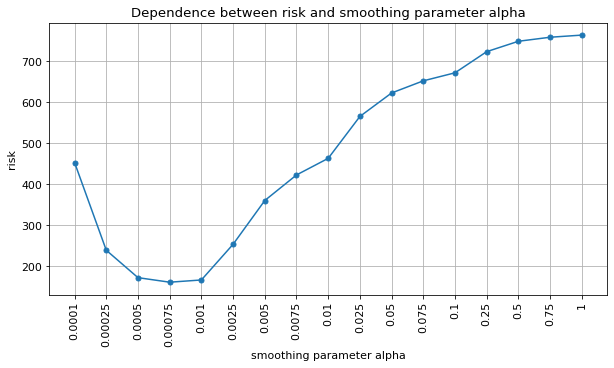

In [11]:
plot_risk_from_alpha(M, risk_homo)

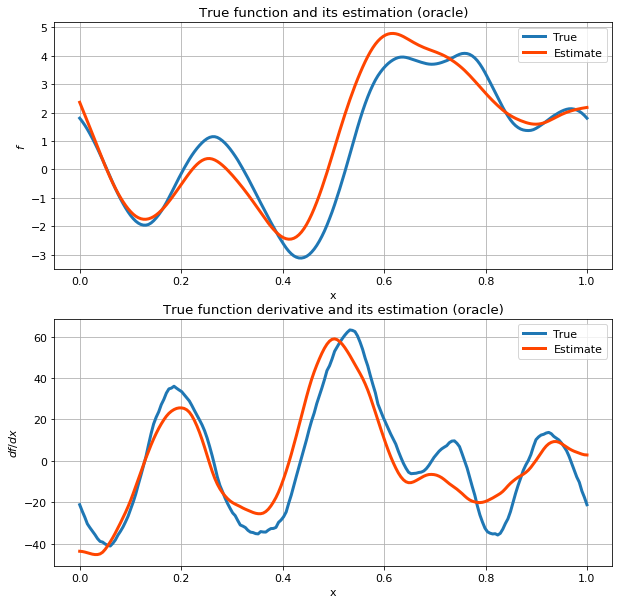

In [12]:
plot_true_and_oracle(x, f_true_x, f_oracle_homo, df_true_x, df_oracle_homo)

### Inhomogeneous erros

In [13]:
print('Family of parameters:', M)
print()
cov = np.diag(var_inhomo)

risk_inhomo, oracle_inhomo, oracle_risk_inhomo, f_oracle_inhomo, df_oracle_inhomo = find_oracle(
    M, x, knots, f_true_x, df_true_x, f_obs_inhomo, cov)

Family of parameters: [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

Smoothing parameter = 0.00010, for functional: loss = 74.584, risk = 160.184
for original function: loss = 0.09

Smoothing parameter = 0.00025, for functional: loss = 88.065, risk = 133.439
for original function: loss = 0.12

Smoothing parameter = 0.00050, for functional: loss = 117.014, risk = 145.254
for original function: loss = 0.19

Smoothing parameter = 0.00075, for functional: loss = 145.026, risk = 166.478
for original function: loss = 0.25

Smoothing parameter = 0.00100, for functional: loss = 170.962, risk = 188.633
for original function: loss = 0.32

Smoothing parameter = 0.00250, for functional: loss = 284.838, risk = 294.430
for original function: loss = 0.62

Smoothing parameter = 0.00500, for functional: loss = 386.224, risk = 392.308
for original function: loss = 0.92

Smoothing parameter = 0.00750, for functional: loss = 442.201, ri

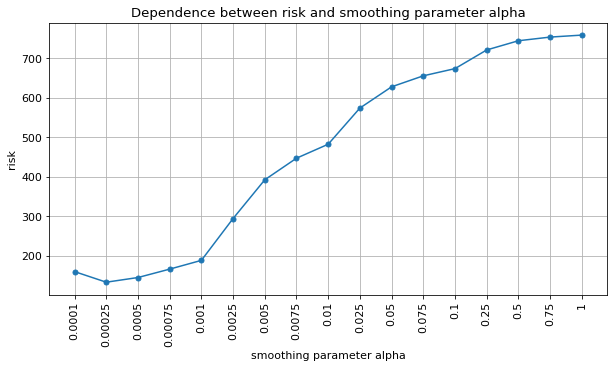

In [14]:
plot_risk_from_alpha(M, risk_inhomo)

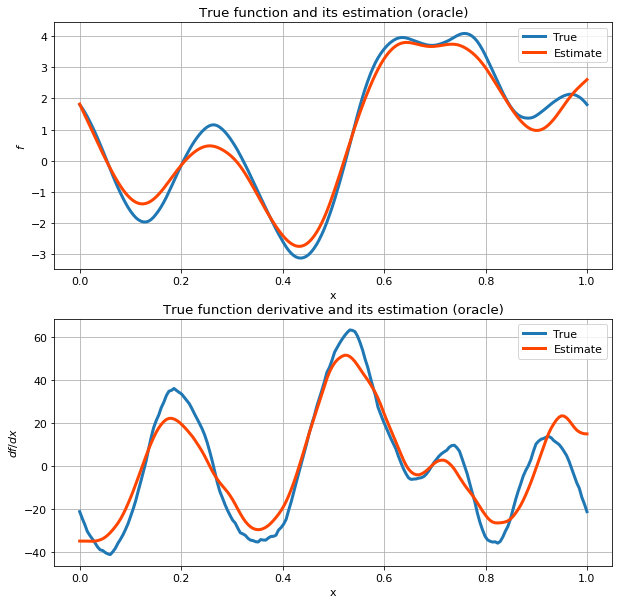

In [15]:
plot_true_and_oracle(x, f_true_x, f_oracle_inhomo, df_true_x, df_oracle_inhomo)

### Step 4: adaptive choice of the parameter: Unbiased risk estimation

We suppose that our collection of models contains the largest model $M$ with vanishing bias $b_M$. 

Unbiased estimate of the risk:

$$ \hat{R}_m = \frac{1}{n} \left(||\tilde{\phi}_M - \tilde{\phi}_m||^2 + p_m - p_{M, m} \right) $$

For the case with covariance matrix $\sigma^2 I_n$

$$ p_m - p_{M, m} = 2 \sigma^2 tr \left(K_m K_M^{\top} \right) - \sigma^2 tr \left(K_M K_M^{\top} \right) $$

$$ \hat{m} = \underset{m \in M} \arg \min \hat{R}_m $$

When we perform a model selection procedure, we are given only the mean value of the variances. Thus, we deal with the case of misspecified noise and take a unit matrix multiplied by the mean variance as the covariance matrix, while construct the estimates.

In [16]:
def compute_risk_URE(dfM, dfm, var, Km, KM):
    det_term = np.linalg.norm(dfM - dfm)**2 
    stoch_term = 2 * var * np.trace(Km @ KM.T) - var * np.trace(KM @ KM.T)
    return (det_term + stoch_term) / dfM.shape[0]

For the largest model we take the model with mimimal $\alpha$ because it corresponds to the model with the smallest bias.

In [17]:
def select_model_URE(M, x, knots, f_obs, dfM, KM, var):
    estimates = [] # for original function
    destimates = [] # for derivative
    risk_URE_values = []
    for alpha in M:
        spline = SmoothingSpline(knots, f_obs, alpha=alpha)
        f_est = spline(x)
        df_est = spline.derivative(x)
        Km = spline.compute_K(x)

        estimates.append(f_est)
        destimates.append(df_est)
        R = compute_risk_URE(dfM, df_est, var, Km, KM)
        risk_URE_values.append(R)

        print('Smoothing parameter = %.5f, risk_URE = %.3f' % (alpha, R))
    
    best_ind = np.argmin(risk_URE_values)
    alpha_URE = M[best_ind]
    risk_URE = risk_URE_values[best_ind]
    f_URE = estimates[best_ind]
    df_URE = destimates[best_ind]
    
    print('\n...Adaptive choice alpha = %.5f, risk_URE = %.3f' % (alpha_URE, risk_URE))
    
    return risk_URE_values, alpha_URE, risk_URE, f_URE, df_URE

def plot_risk_URE_from_alpha(M, risk_values):
    plt.rcParams.update({'font.size': 11})
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(M)), risk_values, marker='o', markersize=5)
    plt.xticks(np.arange(len(M)), M, rotation='vertical')
    plt.title('Dependence between URE risk and smoothing parameter alpha')
    plt.xlabel('smoothing parameter alpha')
    plt.ylabel('URE risk')
    plt.grid()
    plt.show()
    
def plot_true_USE_risk(M, true_risk, URE_risk):
    plt.rcParams.update({'font.size': 11})
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(M)), true_risk, marker='o', markersize=5, label='True risk')
    plt.plot(np.arange(len(M)), URE_risk, marker='o', markersize=5, label='URE risk')
    plt.xticks(np.arange(len(M)), M, rotation='vertical')
    plt.title('URE risk and true risk')
    plt.xlabel('smoothing parameter alpha')
    plt.ylabel('risk')
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_excess_risk(M, oracle_risk, risk_values):
    excess = risk_values - oracle_risk
    plt.rcParams.update({'font.size': 11})
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(M)), excess, marker='o', markersize=5)
    plt.xticks(np.arange(len(M)), M, rotation='vertical')
    plt.title('Excess risk')
    plt.xlabel('smoothing parameter alpha')
    plt.ylabel('excess risk')
    plt.grid()
    plt.show()

### Homogeneous errors

In [18]:
# largest model

smooth_spline = SmoothingSpline(knots, f_obs_homo, alpha=M[0])
fM = smooth_spline(x)
dfM = smooth_spline.derivative(x)
KM = smooth_spline.compute_K(x)

# model selection

print('Family of parameters:', M[1:])
print()

risk_URE_values_homo, alpha_URE_homo, risk_URE_homo, f_URE_homo, df_URE_homo = select_model_URE(
    M[1:], x, knots, f_obs_homo, dfM, KM, var_homo)

Family of parameters: [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

Smoothing parameter = 0.00025, risk_URE = 118.381
Smoothing parameter = 0.00050, risk_URE = 180.727
Smoothing parameter = 0.00075, risk_URE = 239.596
Smoothing parameter = 0.00100, risk_URE = 292.297
Smoothing parameter = 0.00250, risk_URE = 509.523
Smoothing parameter = 0.00500, risk_URE = 687.138
Smoothing parameter = 0.00750, risk_URE = 779.941
Smoothing parameter = 0.01000, risk_URE = 838.057
Smoothing parameter = 0.02500, risk_URE = 981.541
Smoothing parameter = 0.05000, risk_URE = 1061.507
Smoothing parameter = 0.07500, risk_URE = 1102.179
Smoothing parameter = 0.10000, risk_URE = 1128.660
Smoothing parameter = 0.25000, risk_URE = 1196.356
Smoothing parameter = 0.50000, risk_URE = 1228.548
Smoothing parameter = 0.75000, risk_URE = 1240.821
Smoothing parameter = 1.00000, risk_URE = 1247.270

...Adaptive choice alpha = 0.00025, risk_URE = 118.381


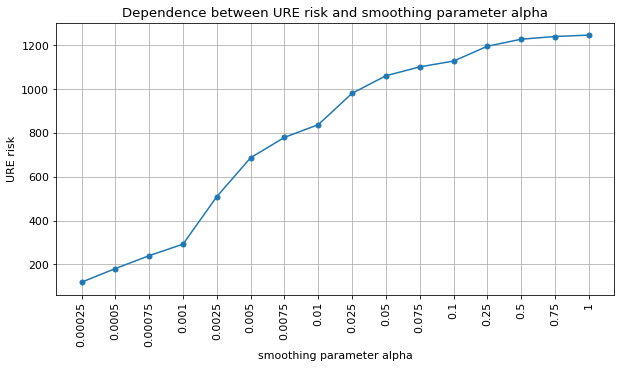

In [19]:
plot_risk_URE_from_alpha(M[1:], risk_URE_values_homo)

Compare the risk estimate and the true risk:

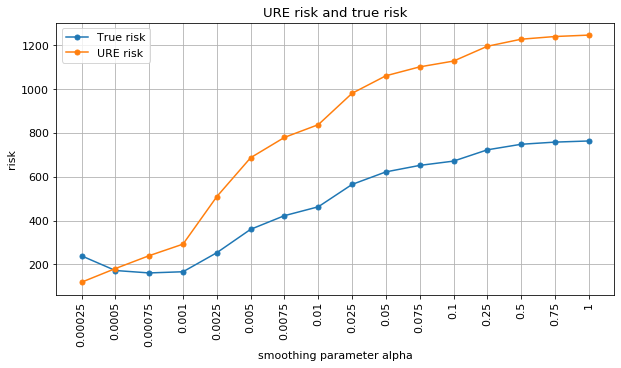

In [20]:
plot_true_USE_risk(M[1:], risk_homo[1:], risk_URE_values_homo)

**Excess risk** = the difference between the adaptive risk for the chosen parameter and the best oracle risk. 

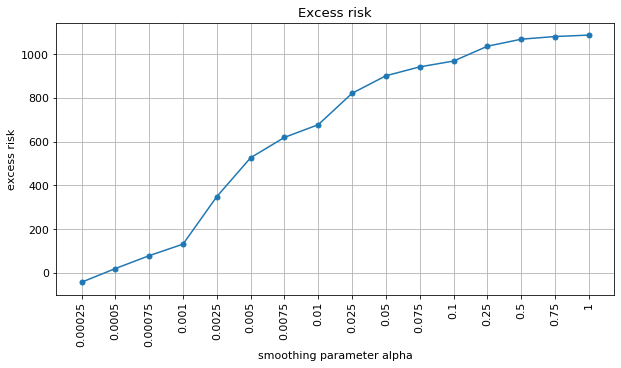

In [21]:
plot_excess_risk(M[1:], oracle_risk_homo, risk_URE_values_homo)

### Inhomogeneous erros

In [22]:
# largest model

smooth_spline = SmoothingSpline(knots, f_obs_inhomo, alpha=M[0])
fM = smooth_spline(x)
dfM = smooth_spline.derivative(x)
KM = smooth_spline.compute_K(x)

# model selection
# take mean values for variance

risk_URE_values_inhomo, alpha_URE_inhomo, risk_URE_inhomo, f_URE_inhomo, df_URE_inhomo = select_model_URE(
    M[1:], x, knots, f_obs_inhomo, dfM, KM, np.mean(var_inhomo)) 

Smoothing parameter = 0.00025, risk_URE = 48.451
Smoothing parameter = 0.00050, risk_URE = 49.542
Smoothing parameter = 0.00075, risk_URE = 63.832
Smoothing parameter = 0.00100, risk_URE = 80.940
Smoothing parameter = 0.00250, risk_URE = 171.431
Smoothing parameter = 0.00500, risk_URE = 259.669
Smoothing parameter = 0.00750, risk_URE = 309.073
Smoothing parameter = 0.01000, risk_URE = 340.717
Smoothing parameter = 0.02500, risk_URE = 419.557
Smoothing parameter = 0.05000, risk_URE = 463.482
Smoothing parameter = 0.07500, risk_URE = 486.105
Smoothing parameter = 0.10000, risk_URE = 501.075
Smoothing parameter = 0.25000, risk_URE = 540.836
Smoothing parameter = 0.50000, risk_URE = 561.165
Smoothing parameter = 0.75000, risk_URE = 569.425
Smoothing parameter = 1.00000, risk_URE = 573.950

...Adaptive choice alpha = 0.00025, risk_URE = 48.451


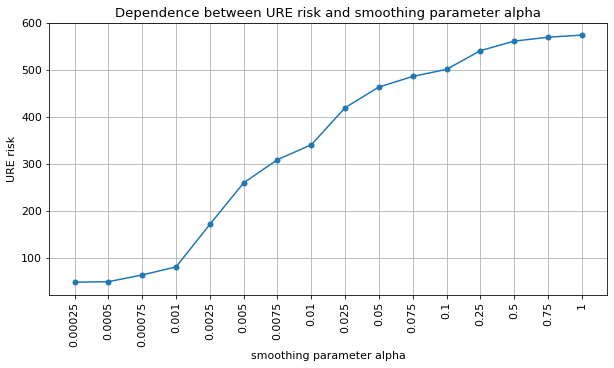

In [23]:
plot_risk_URE_from_alpha(M[1:], risk_URE_values_inhomo)

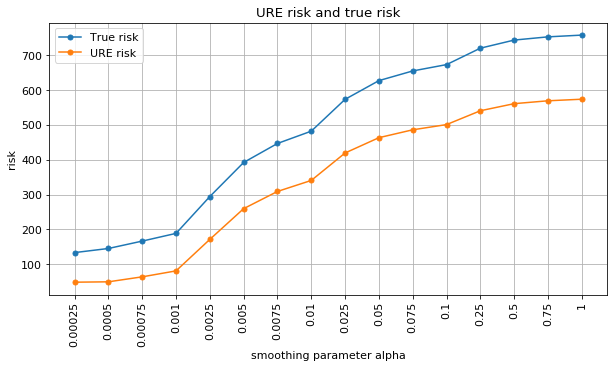

In [24]:
plot_true_USE_risk(M[1:], risk_inhomo[1:], risk_URE_values_inhomo)

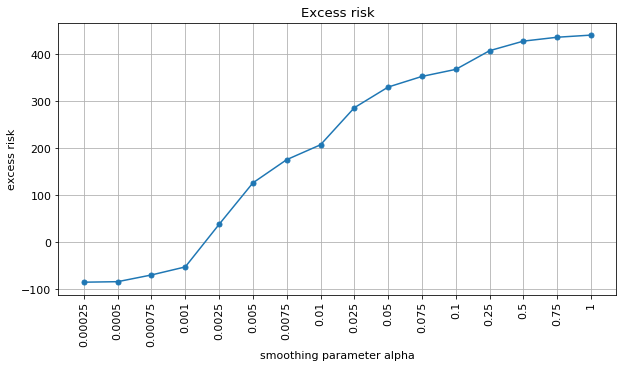

In [25]:
plot_excess_risk(M[1:], oracle_risk_inhomo, risk_URE_values_inhomo)

**Resulting plots**

Visualization of the true function $f^∗$ and the target function $(f^∗)'$. Visualization of the oracle estimate and the adaptive estimate on the same plot as the target function.

In [26]:
def plot_results(x, f_true, f_oracle, f_URE, df_true, df_oracle, df_URE):
    plt.rcParams.update({'font.size': 11})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    ax1.plot(x, f_true, linewidth=3, label='True')
    ax1.plot(x, f_oracle, linewidth=3, label='Oracle')
    ax1.plot(x, f_URE, linewidth=3, label='URE')
    ax1.set_title('True function, oracle estimation and adaptive estimation')
    ax1.set_xlabel('x')
    ax1.set_ylabel('$f$')
    ax1.grid()
    ax1.legend()
    
    ax2.plot(x, df_true, linewidth=3, label='True')
    ax2.plot(x, df_oracle, linewidth=3, label='Oracle')
    ax2.plot(x, df_URE, linewidth=3, label='URE')
    ax2.set_title('Derivative: true function, oracle estimation and adaptive estimation')
    ax2.set_xlabel('x')
    ax2.set_ylabel('$df/dx$')
    ax2.grid()
    ax2.legend()
    
    plt.show()

### Homogeneous erros

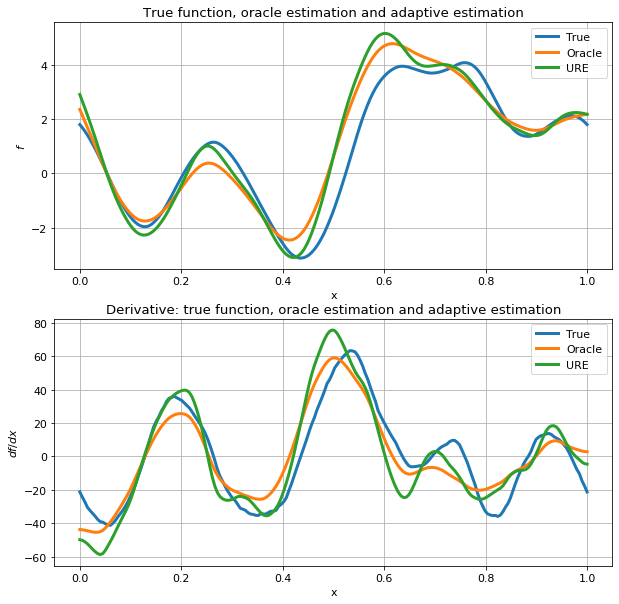

In [27]:
plot_results(x, f_true_x, f_oracle_homo, f_URE_homo, 
             df_true_x, df_oracle_homo, df_URE_homo)

### Inhomogneous errors

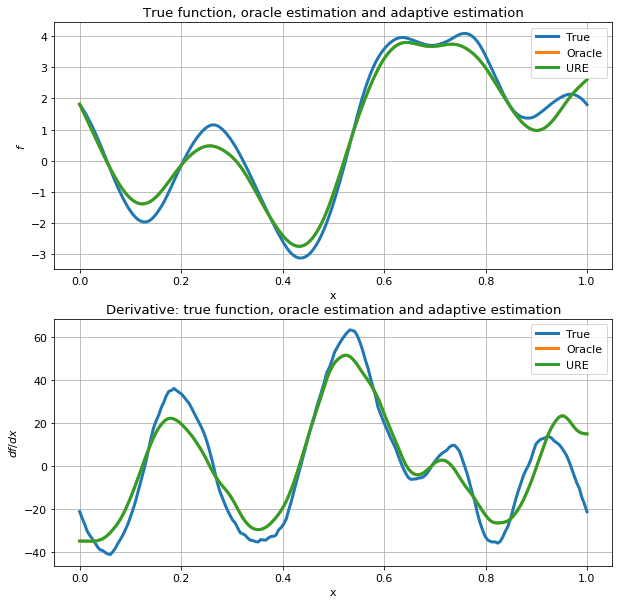

In [28]:
plot_results(x, f_true_x, f_oracle_inhomo, f_URE_inhomo, 
             df_true_x, df_oracle_inhomo, df_URE_inhomo)

For inhomogeneous noise we got $m^*=\hat{m}$.